<a href="https://colab.research.google.com/github/CalvinKorver/triathlon_model/blob/main/Triathlon_Stage_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cjkorv3r (cjkorv3r-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

Mounted at /content/gdrive


In [4]:
def search_images_unsplash_batch(query, total_images=100, per_page=30):
    access_key = "ThvQXxYpu1Obvf56Q3TIEhnHLE6aNtSSo3PQZLEORmc"  # Get free key from unsplash.com/developers
    url = "https://api.unsplash.com/search/photos"

    headers = {"Authorization": f"Client-ID {access_key}"}
    all_urls = []

    # Calculate how many pages we need
    pages_needed = (total_images + per_page - 1) // per_page

    for page in range(1, pages_needed + 1):
        params = {
            "query": query,
            "per_page": per_page,
            "page": page
        }

        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()

            data = response.json()
            page_urls = [photo["urls"]["regular"] for photo in data["results"]]
            all_urls.extend(page_urls)

            # Break if we have enough images
            if len(all_urls) >= total_images:
                break

            # Rate limit: Unsplash allows 50 requests per hour for free tier
            time.sleep(1)  # Be respectful to API

        except requests.exceptions.RequestException as e:
            print(f"Error fetching page {page}: {e}")
            break

    return all_urls[:total_images]

In [7]:
import os
from pathlib import Path
from google.colab import drive
import requests
from PIL import Image
import time

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define Google Drive path
drive_path = Path('/content/drive/MyDrive/triathlon')
stages = ['swim', 'run', 'bike', 'transition']

# Create base directory in Google Drive
if not drive_path.exists():
    drive_path.mkdir(parents=True)
    print(f"Created directory: {drive_path}")

def check_existing_images(folder_path, target_count=50):
    """Check how many images already exist in the folder"""
    if not folder_path.exists():
        return 0

    image_extensions = {'.jpg', '.jpeg', '.png', '.webp', '.gif'}
    existing_images = [
        f for f in folder_path.iterdir()
        if f.suffix.lower() in image_extensions
    ]
    return len(existing_images)

def download_images_safe(dest_folder, urls, existing_count=0, target_count=50):
    """Download images with error handling and progress tracking"""
    needed_count = target_count - existing_count

    if needed_count <= 0:
        print(f"Already have {existing_count} images, skipping download")
        return

    print(f"Need to download {needed_count} more images (have {existing_count})")

    downloaded = 0
    for i, url in enumerate(urls):
        if downloaded >= needed_count:
            break

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()

            # Generate filename
            filename = f"image_{existing_count + downloaded + 1:03d}.jpg"
            filepath = dest_folder / filename

            # Save image
            with open(filepath, 'wb') as f:
                f.write(response.content)

            # Verify it's a valid image
            try:
                with Image.open(filepath) as img:
                    img.verify()
                downloaded += 1
                print(f"Downloaded {filename}")
            except Exception as e:
                print(f"Invalid image, removing: {filename}")
                filepath.unlink()

        except Exception as e:
            print(f"Error downloading image {i+1}: {e}")
            continue

        # Small delay to be respectful to the API
        time.sleep(0.1)

    print(f"Downloaded {downloaded} new images")

# Process each stage
for stage in stages:
    print(f"\n--- Processing {stage} ---")

    # Create stage directory in Google Drive
    stage_folder = drive_path / stage
    stage_folder.mkdir(exist_ok=True)

    # Check existing images
    existing_count = check_existing_images(stage_folder)
    print(f"Found {existing_count} existing images for {stage}")

    # Only search and download if we need more images
    if existing_count < 10:  # Target 50 images per stage
        print(f"Searching for triathlon {stage} images...")

        # Your existing search function
        results = search_images_unsplash_batch(f'triathlon {stage}', total_images=50)

        if results:
            download_images_safe(
                stage_folder,
                urls=results,
                existing_count=existing_count,
                target_count=50
            )
        else:
            print(f"No results found for {stage}")
    else:
        print(f"Stage {stage} already has images... ({existing_count})")

print("\n--- Summary ---")
for stage in stages:
    stage_folder = drive_path / stage
    count = check_existing_images(stage_folder)
    print(f"{stage}: {count} images")

print(f"\nAll images saved to: {drive_path}")

Mounted at /content/drive

--- Processing swim ---
Found 50 existing images for swim
Stage swim already has images... (50)

--- Processing run ---
Found 41 existing images for run
Stage run already has images... (41)

--- Processing bike ---
Found 62 existing images for bike
Stage bike already has images... (62)

--- Processing transition ---
Found 38 existing images for transition
Stage transition already has images... (38)

--- Summary ---
swim: 50 images
run: 41 images
bike: 62 images
transition: 38 images

All images saved to: /content/drive/MyDrive/triathlon


In [8]:
photos = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
path = Path('/content/drive/MyDrive/triathlon')
dls = photos.dataloaders(path)


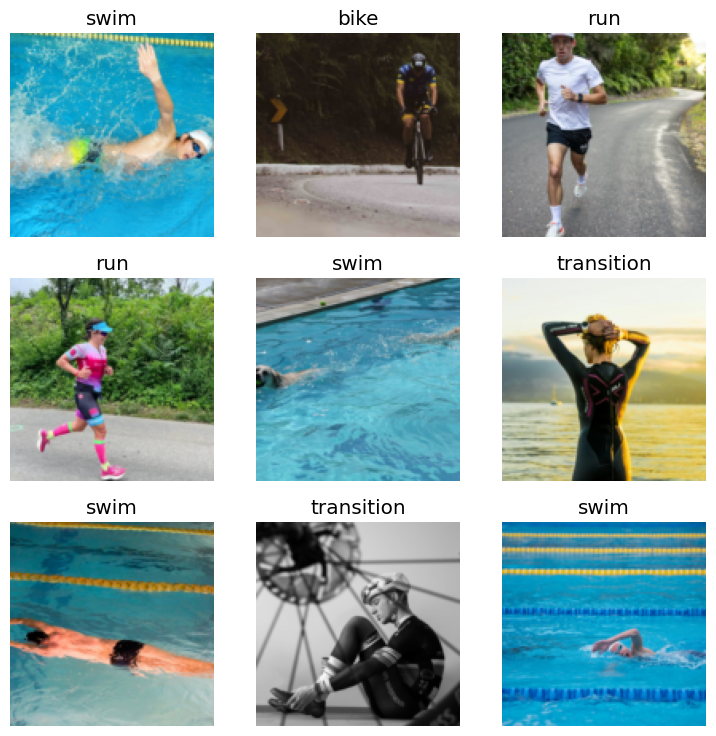

In [10]:
dls.valid.show_batch()

In [11]:
from collections import Counter

# Get the list of labels for the training set
train_labels = [dls.vocab[item[1]] for item in dls.train_ds]
train_counts = Counter(train_labels)

# Get the list of labels for the validation set
valid_labels = [dls.vocab[item[1]] for item in dls.valid_ds]
valid_counts = Counter(valid_labels)

print("Training Set Distribution:")
for label, count in train_counts.items():
    print(f"  {label}: {count}")

print("\nValidation Set Distribution:")
for label, count in valid_counts.items():
    print(f"  {label}: {count}")

Training Set Distribution:
  swim: 37
  transition: 31
  run: 33
  bike: 52

Validation Set Distribution:
  swim: 13
  bike: 10
  run: 8
  transition: 7


In [12]:
photos = photos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = photos.dataloaders(path)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)
# learn.show_results()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
# learn = vision_learner(dls, resnet18, metrics=error_rate)
# learn.fine_tune(4)
# learn.show_results()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()
interp.plot_top_losses(5, nrows=1)

In [14]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# import shutil
# from pathlib import Path
# import os

# # Delete selected images
# print("Deleting selected images...")
# deleted_count = 0
# for idx in cleaner.delete():
#     try:
#         cleaner.fns[idx].unlink()
#         deleted_count += 1
#         print(f"Deleted: {cleaner.fns[idx].name}")
#     except Exception as e:
#         print(f"Error deleting {cleaner.fns[idx].name}: {e}")

# print(f"Deleted {deleted_count} images")

# # Move/rename selected images with collision handling
# print("\nMoving/renaming selected images...")
# moved_count = 0
# for idx, cat in cleaner.change():
#     src_path = cleaner.fns[idx]
#     dest_dir = path / cat
#     dest_path = dest_dir / src_path.name

#     try:
#         # If destination exists, create a unique filename
#         if dest_path.exists():
#             # Create a unique filename by adding a counter
#             counter = 1
#             stem = src_path.stem
#             suffix = src_path.suffix

#             while dest_path.exists():
#                 new_name = f"{stem}_{counter:03d}{suffix}"
#                 dest_path = dest_dir / new_name
#                 counter += 1

#             print(f"Destination exists, using new name: {dest_path.name}")

#         # Move the file
#         shutil.move(str(src_path), str(dest_path))
#         moved_count += 1
#         print(f"Moved: {src_path.name} -> {cat}/{dest_path.name}")

#     except Exception as e:
#         print(f"Error moving {src_path.name}: {e}")

# print(f"Moved {moved_count} images")
# print("\nCleaning complete!")

# # Optional: Show updated dataset statistics
# print("\n=== Updated Dataset Statistics ===")
# total_images = 0
# for category_folder in path.iterdir():
#     if category_folder.is_dir():
#         images = list(category_folder.glob('*'))
#         count = len(images)
#         total_images += count
#         print(f"{category_folder.name}: {count} images")

# print(f"\nTotal: {total_images} images")

Deleting selected images...


NameError: name 'cleaner' is not defined

In [ ]:
# # Get the current list of files after deletion and moving
# fns_after_cleaning = get_image_files(path)

# # Print the number of files before and after cleaning for comparison
# print(f"Number of files before cleaning: {len(fns)}")
# print(f"Number of files after cleaning: {len(fns_after_cleaning)}")

# # Optionally, you can also list the files in each category folder to see the changes
# for o in bear_types:
#     print(f"Number of files in '{o}' folder after cleaning: {len(get_image_files(path/o))}")

In [ ]:
!pip install wandb -qU

In [20]:
# Log in to your W&B account
import wandb
import random
import math

In [16]:
from fastai.vision.all import *
import torch


# 2. Create the learner
learn = vision_learner(dls, resnet18, metrics=error_rate)

# 3. Temporarily override torch.load to allow unsafe loading
original_load = torch.load
def safe_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return original_load(*args, **kwargs)

torch.load = safe_load

# 4. Now load your model
learn.load('triathlon_stage_model')

# 5. Restore original torch.load
torch.load = original_load

# 6. Export properly
learn.export('models/triathlon_stage_model.pkl')

print("Model exported successfully!")


Model exported successfully!


In [56]:
from fastai.callback.wandb import *

numEpochs = 4
projectName = "Triathlon Phase Image Classifier"
entityName = "cjkorv3r-self"

# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity=entityName,
    # Set the wandb project where this run will be logged.
    project=projectName,
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "resnet18",
        "dataset": "triathlon",
        "epochs": numEpochs,
    },
    dir="/temp",
    notes="I cleaned up the run photos. There were lots that were not running related. Then i added more 'pure' running shots"
)

# Refresh the dataloaders with cleaned data
dls = photos.dataloaders(path)
print(f"New classes: {dls.vocab}")
print(f"Training: {len(dls.train_ds)}, Validation: {len(dls.valid_ds)}")

learn = vision_learner(dls, resnet18, metrics=error_rate, cbs=WandbCallback())  # Bigger model
learn.fine_tune(numEpochs)


run.finish()

New classes: ['bike', 'run', 'swim', 'transition']
Training: 153, Validation: 38


In [57]:
learn_clean = vision_learner(dls, resnet18, metrics=error_rate)
learn_clean.fine_tune(numEpochs)

TTA accuracy: 0.8158


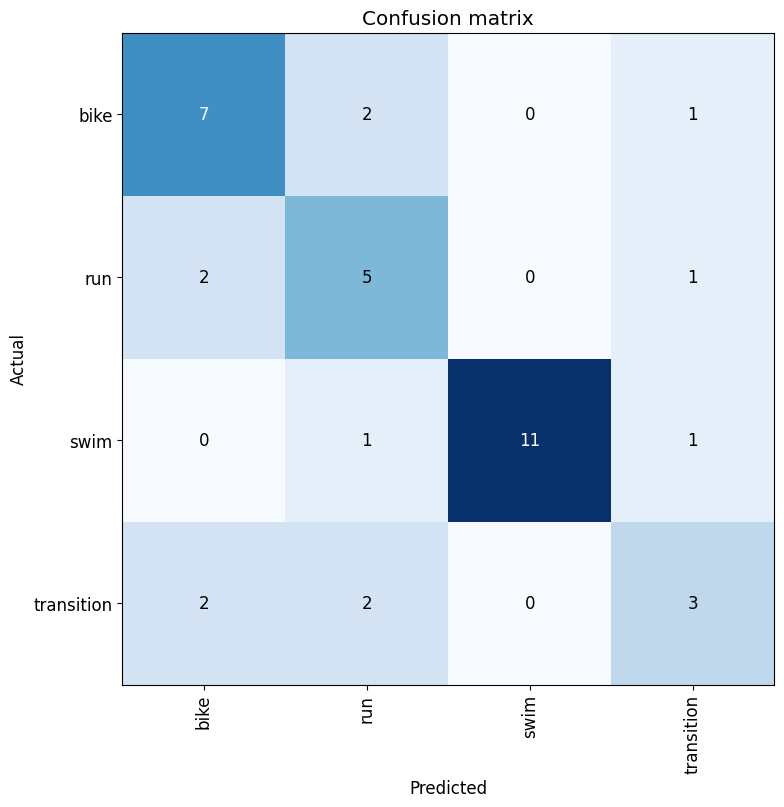

In [58]:
interp = ClassificationInterpretation.from_learner(learn_clean)

preds_tta, targets = learn_clean.tta()
tta_accuracy = accuracy(preds_tta, targets).item()
print(f"TTA accuracy: {tta_accuracy:.4f}")

# And the confusion matrix - should be nearly diagonal now
interp.plot_confusion_matrix(figsize=(10, 8)) # Added figsize parameter

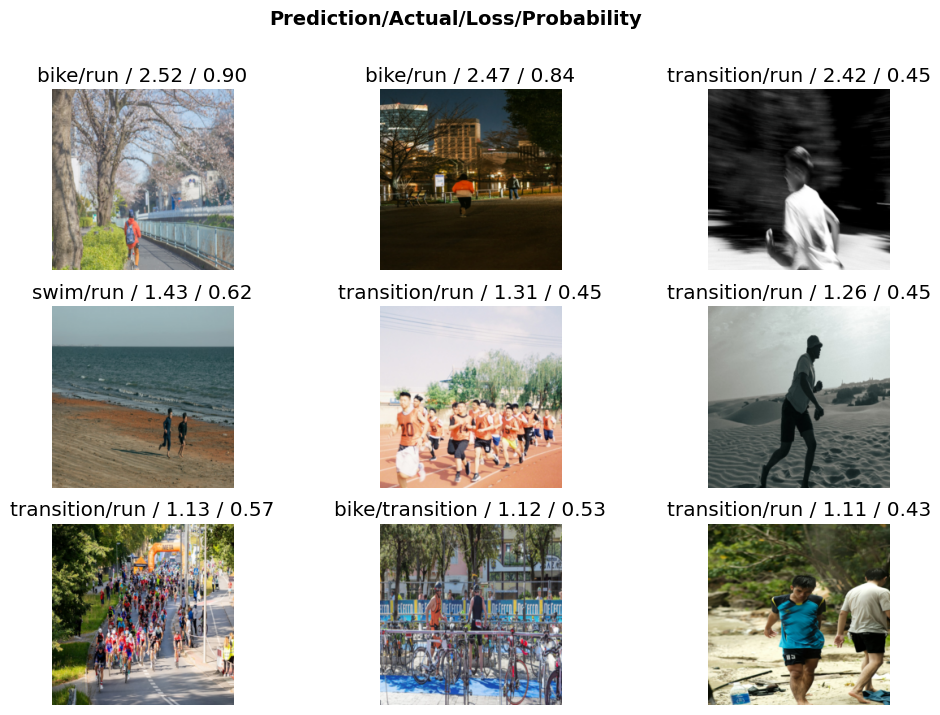

In [49]:
interp.most_confused(min_val=2)
interp.plot_top_losses(k=9, figsize=(12,8), largest=True)

### Try test-time augmentation for even better results

In [ ]:
# Regular predictions
preds_regular, targets = learn_clean.get_preds()
regular_accuracy = accuracy(preds_regular, targets).item()

# TTA predictions
preds_tta, targets = learn_clean.tta()
tta_accuracy = accuracy(preds_tta, targets).item()

print(f"Regular accuracy: {regular_accuracy:.4f}")
print(f"TTA accuracy: {tta_accuracy:.4f}")
print(f"Improvement: {tta_accuracy - regular_accuracy:.4f}")


TypeError: unsupported format string passed to TensorBase.__format__

In [ ]:
print(f"Regular accuracy: {regular_accuracy:.4f}")
print(f"TTA accuracy: {tta_accuracy:.4f}")
print(f"Improvement: {tta_accuracy - regular_accuracy:.4f}")


Regular accuracy: 0.6857
TTA accuracy: 0.7714
Improvement: 0.0857


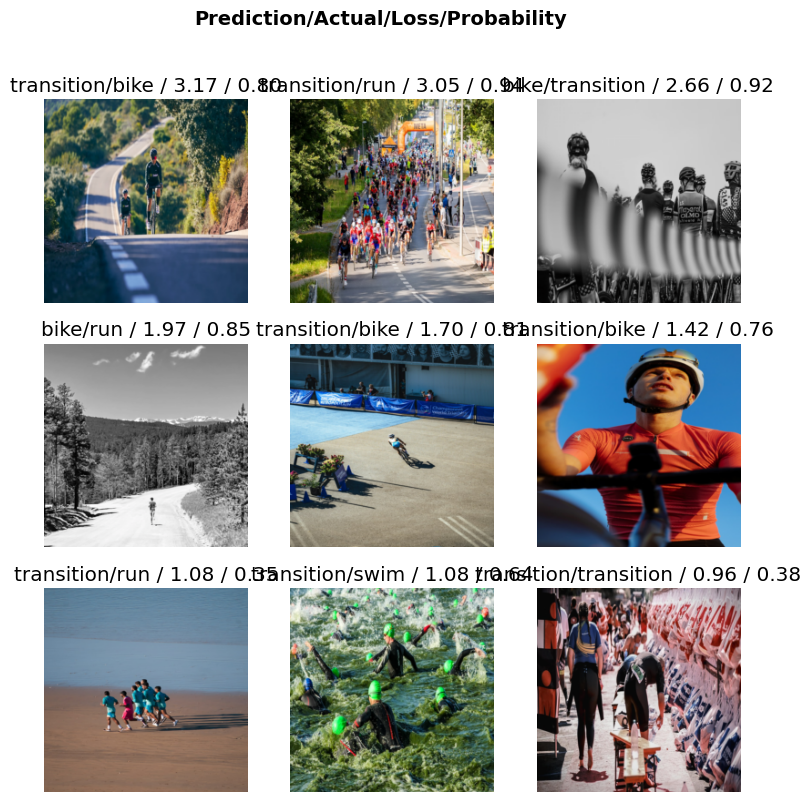

In [ ]:
interp.plot_top_losses(9, figsize=(10, 10))

In [ ]:
# # Method 3: Check for potential mislabeled images using the trained model
# print("\n=== Method 3: Find Potential Mislabels ===")
# # Note: Run this after training your model

# def check_predictions(learn, top_k=10):
#     """Find images where the model is most confused"""

#     # Get predictions for validation set
#     probs, targets, preds = learn.get_preds()

#     # Calculate loss for each prediction
#     losses = F.cross_entropy(probs, targets, reduction='none')

#     # Get indices of highest loss (most confused predictions)
#     top_losses, top_idxs = losses.topk(top_k)

#     print(f"Top {top_k} potentially mislabeled images:")

#     for i, idx in enumerate(top_idxs):
#         img_path = learn.dls.valid_ds.items[idx]
#         actual_label = learn.dls.vocab[targets[idx]]
#         predicted_label = learn.dls.vocab[preds[idx]]
#         confidence = probs[idx].max().item()

#         print(f"{i+1}. {img_path.name}")
#         print(f"   Folder: {actual_label}")
#         print(f"   Model predicts: {predicted_label} ({confidence:.2%} confidence)")
#         print(f"   Loss: {top_losses[i]:.3f}")
#         print()

# # Uncomment this line after you've trained your model:
# check_predictions(learn)

In [59]:
learn.save('triathlon_stage_model')

Path('models/triathlon_stage_model.pth')